In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, repeat, combinations
from scipy.interpolate import UnivariateSpline
import pandas as pd
from os import listdir
from scipy.stats import norm

%matplotlib inline

## Image preprocessing

In [2]:
def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.xticks([]), plt.yticks([])

In [3]:
files = listdir('../data')
filename = '../data/' + files[np.random.randint(0, len(files))]

In [4]:
#filename = '../data/dcnp8.png'

In [5]:
original = cv.cvtColor(cv.imread(filename), cv.COLOR_RGB2GRAY)

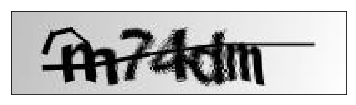

In [6]:
show_image(original)

Invert pixel intensities

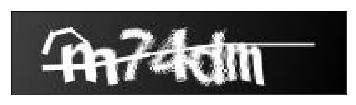

In [7]:
original_inverted = 255 - original
show_image(original_inverted)

Apply thresholding

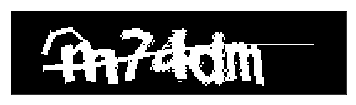

In [42]:
ret, thresholded = cv.threshold(original_inverted, 140, 255, cv.THRESH_BINARY)
show_image(thresholded)

Apply median blur to reduce noise

In [43]:
blurred = cv.medianBlur(thresholded, 3)
# blurred = cv.bilateralFilter(thresholded, 21, 100, 200)

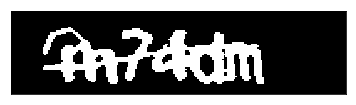

In [44]:
show_image(blurred)

Apply a mask to the image to reduce tiny objects and horizontal lines

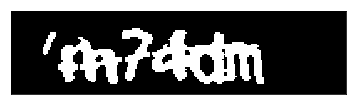

In [45]:
kernel = np.array([
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
]).astype(np.uint8)
kernel2 = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]
]).astype(np.uint8)

mask = cv.morphologyEx(blurred, cv.MORPH_OPEN, kernel)
mask = cv.morphologyEx(mask, cv.MORPH_DILATE, kernel2)
processed = (((mask > 0) & (blurred > 0)) * 255).astype(np.uint8)

show_image(processed)

Apply edge detector

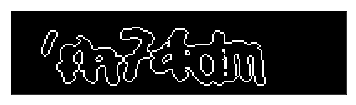

In [46]:
edges = cv.Laplacian(processed, 5).clip(0, 255).astype(np.uint8)
show_image(edges)

## Find image contours

In [28]:
contours, hierachy = cv.findContours(edges, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE )

In [29]:
rects = [cv.boundingRect(contour) for contour in contours]
rects_width, rects_height = [rect[2] for rect in rects], [rect[3] for rect in rects]
rects_ratio = [rect[2] / rect[3] for rect in rects]
rects_area = [width * height for width, height in zip(rects_width, rects_height)]

areas = [cv.contourArea(contour) for contour in contours]
extent = [float(area) / rect_area for rect_area, area in zip(rects_area, areas)]

hulls = [cv.convexHull(contour) for contour in contours]
hull_areas = [cv.contourArea(hull) for hull in hulls]

#solidity = [float(area) / hull_area for area, hull_area in zip(areas, hull_areas)]

#eq_diameter = [np.sqrt(4*area/np.pi) for area in areas]

orientation_angles = [cv.fitEllipse(contour)[2] if contour.shape[0] >= 5 else None for contour in contours]

perimeter = [cv.arcLength(contour, True) for contour in contours]


objects_fill_ratio = np.array([(processed[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] > 0).flatten().mean() for rect in rects])

print('Contours properties')
pd.DataFrame.from_dict({
    'width': rects_width,
    'height': rects_height,
    'ratio': np.round(rects_ratio, 2),
    'extent': np.round(extent, 2),
#    'solidity': np.round(solidity, 2),
#    'eq diameter': np.round(eq_diameter, 2),
    'orientation angles': [round(angle, 2) if angle is not None else '---' for angle in orientation_angles],
    'perimeter': np.round(perimeter, 2),
    'obj fill ratio': np.round(objects_fill_ratio, 2)
})

Contours properties


,width,height,ratio,extent,orientation angles,perimeter,obj fill ratio
0,1,1,1.00,0.00,---,0.00,0.00
1,4,13,0.31,0.49,174.82,28.24,0.23
2,4,12,0.33,0.48,179.76,24.49,0.21
3,38,29,1.31,0.55,99.8,150.37,0.42
4,6,6,1.00,0.42,124,15.31,0.39
5,8,9,0.89,0.56,23.72,24.73,0.28
6,13,23,0.57,0.54,165.69,62.87,0.46
7,13,24,0.54,0.54,1.45,63.94,0.46
8,15,28,0.54,0.52,167.3,78.43,0.45
9,10,15,0.67,0.37,25.66,36.63,0.28


In [30]:
hierachy.shape

(1, 21, 4)

In [31]:
print('Contour hierachy info:')
pd.DataFrame.from_dict(dict([(col, data.flatten()) for col, data in
                        zip(['Next', 'Previous', 'First Child', 'Parent'], np.split(hierachy, hierachy.shape[2], axis=2))]))

Contour hierachy info:


,Next,Previous,First Child,Parent
0,1,-1,-1,-1
1,3,0,2,-1
2,-1,-1,-1,1
3,9,1,4,-1
4,5,-1,-1,3
5,6,4,-1,3
6,7,5,-1,3
7,8,6,-1,3
8,-1,7,-1,3
9,11,3,10,-1


In [32]:
n = len(contours)
contour_levels = np.zeros([n]).astype(np.uint8)

contour_parent = hierachy[0, :, 3]
contour_children = [set() for k in range(0, n)]
for k in range(0, n):
    parent = contour_parent[k]
    if parent != -1:
        contour_children[parent].add(k)

A = set(np.nonzero(contour_parent == -1)[0])
B = set(range(0, n)) - A


while len(B) > 0:
    C = set()
    for k in A:
        for child in contour_children[k]:
            B.remove(child)
            C.add(child)
            contour_levels[child] = contour_levels[k] + 1
    A.update(C)

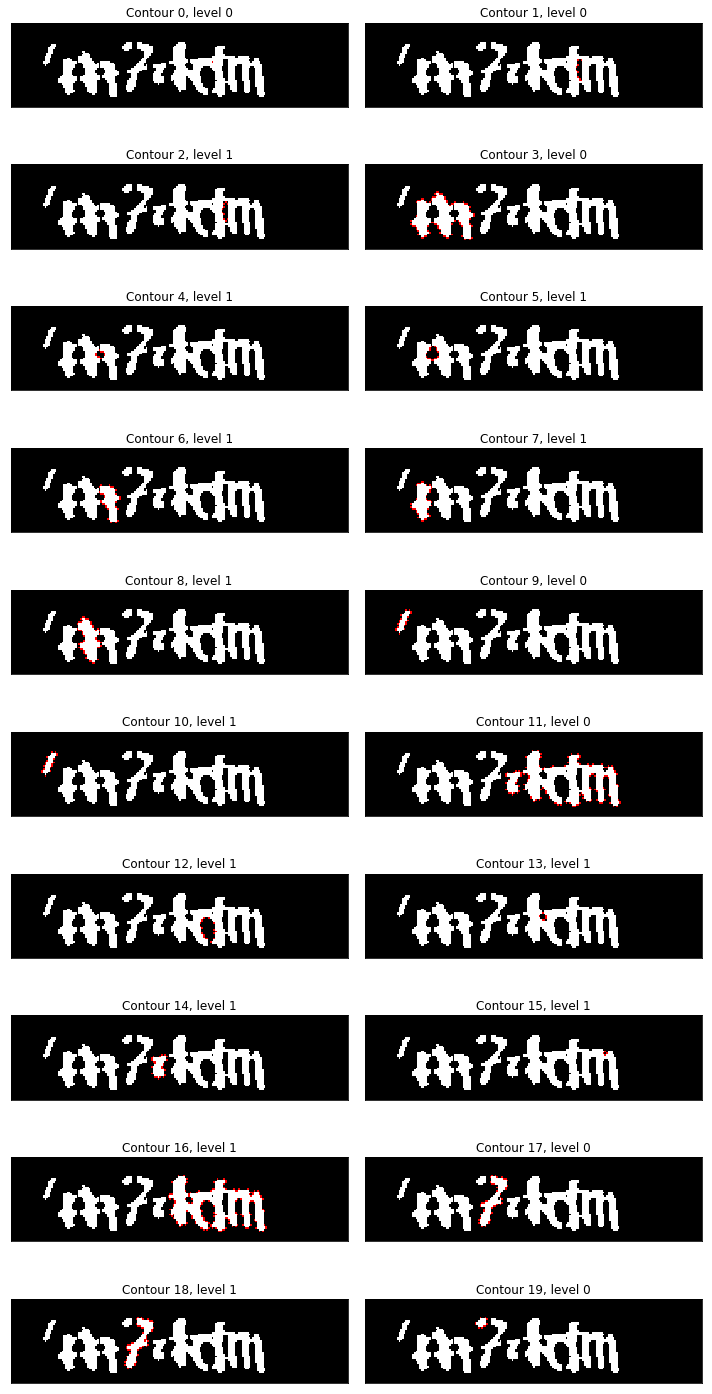

In [33]:
cols = 2
rows = len(contours) // 2
if cols % 2 > 0:
    rows += 1
    
fig, ax = plt.subplots(rows, cols, figsize=(10, rows*2))
for i in range(0, rows):
    for j in range(0, cols):
        index = i * cols + j
        if index >= len(contours):
            ax[i, j].set_visible(False)
        else:
            plt.sca(ax[i, j])
            show_image(cv.drawContours(cv.cvtColor(processed, cv.COLOR_GRAY2RGB), contours[index], -1, (255, 0, 0), -1))
            
            plt.title('Contour {}, level {}'.format(index, contour_levels[index]))
            
plt.tight_layout()
#print(len(contours))

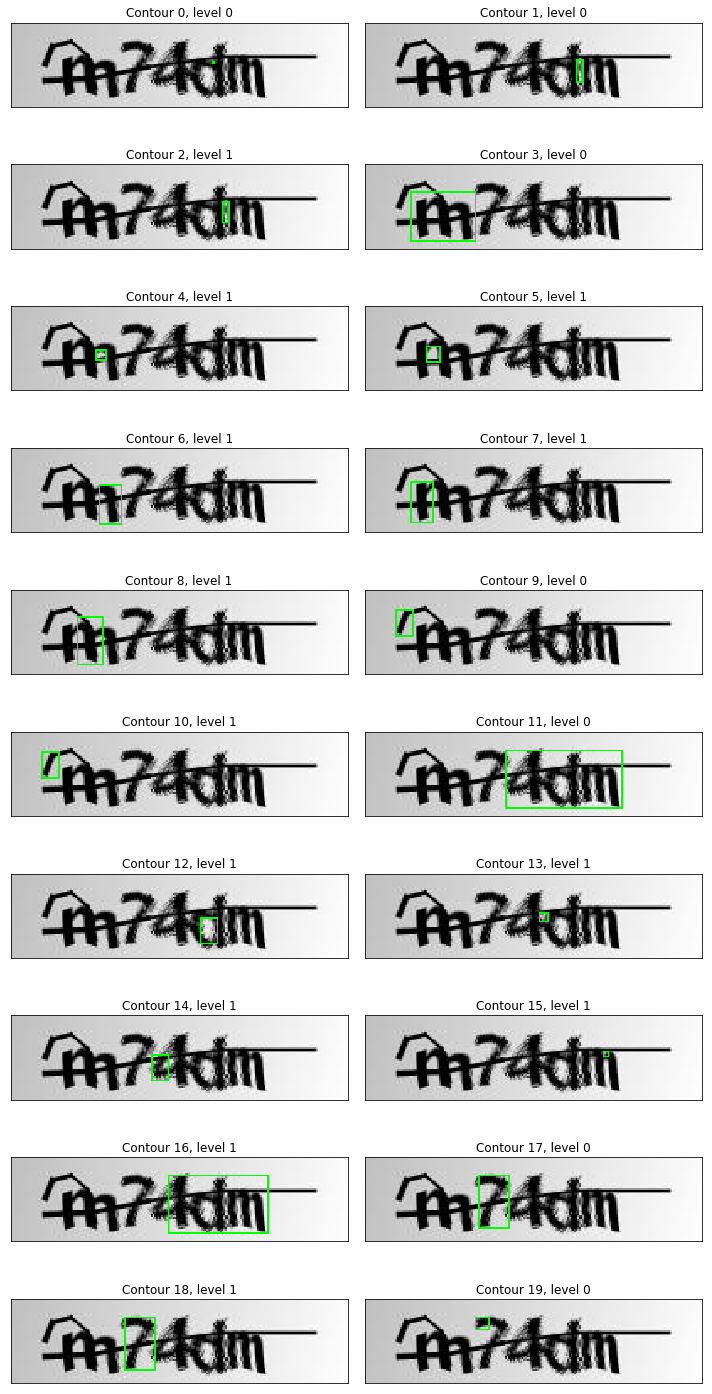

In [34]:
cols = 2
rows = len(contours) // 2
if cols % 2 > 0:
    rows += 1
    
fig, ax = plt.subplots(rows, cols, figsize=(10, rows*2))
for i in range(0, rows):
    for j in range(0, cols):
        index = i * cols + j
        if index >= len(contours):
            ax[i, j].set_visible(False)
        else:
            plt.sca(ax[i, j])
            x,y,w,h = cv.boundingRect(contours[index])
            img = cv.rectangle(cv.cvtColor(original, cv.COLOR_GRAY2RGB),(x,y),(x+w,y+h),(0,255,0),1)
            show_image(img)
            plt.title('Contour {}, level {}'.format(index, contour_levels[index]))
            

plt.tight_layout()

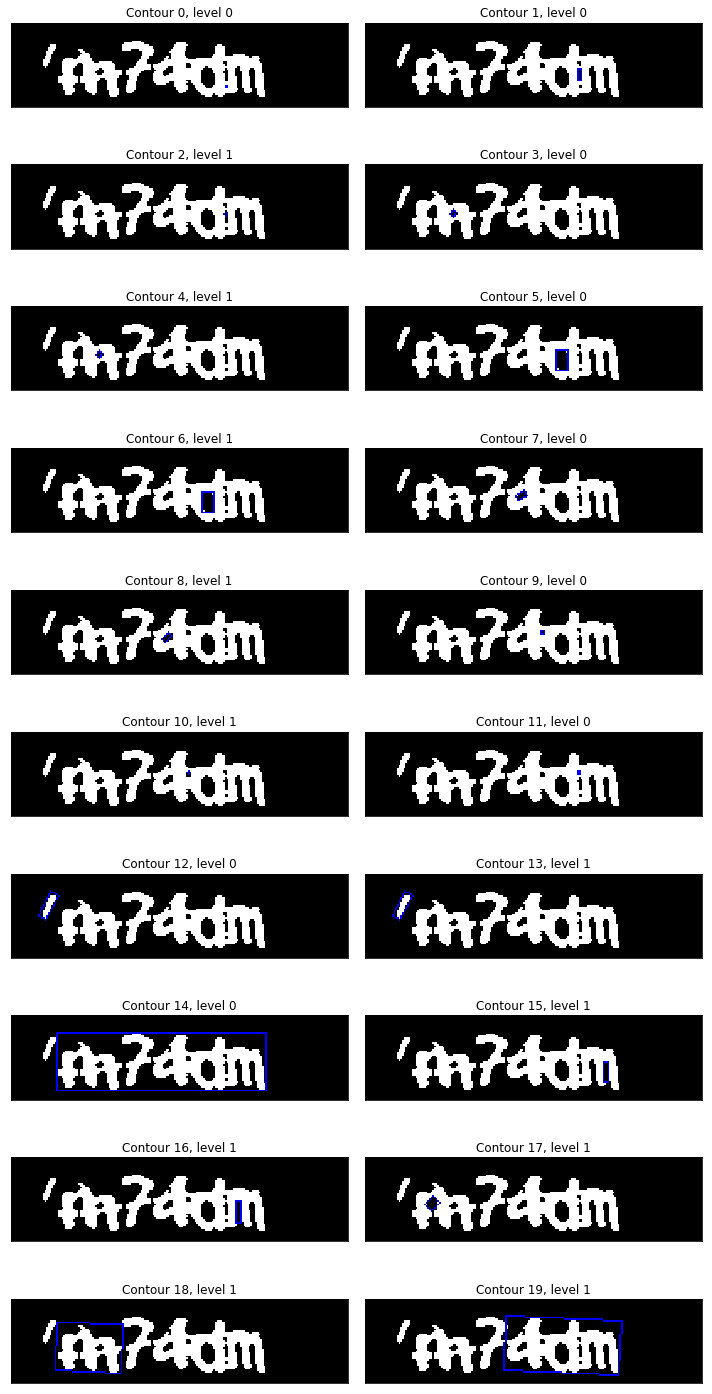

In [20]:
cols = 2
rows = len(contours) // 2
if cols % 2 > 0:
    rows += 1
    
fig, ax = plt.subplots(rows, cols, figsize=(10, rows*2))
for i in range(0, rows):
    for j in range(0, cols):
        index = i * cols + j
        if index >= len(contours):
            ax[i, j].set_visible(False)
        else:
            plt.sca(ax[i, j])
            img = cv.cvtColor(processed, cv.COLOR_GRAY2RGB)
            rect = cv.minAreaRect(contours[index])
            box = cv.boxPoints(rect)
            box = np.int0(box)
            img = cv.drawContours(img,[box],0,(0,0,255),1)
            show_image(img)
            plt.title('Contour {}, level {}'.format(index, contour_levels[index]))

plt.tight_layout()

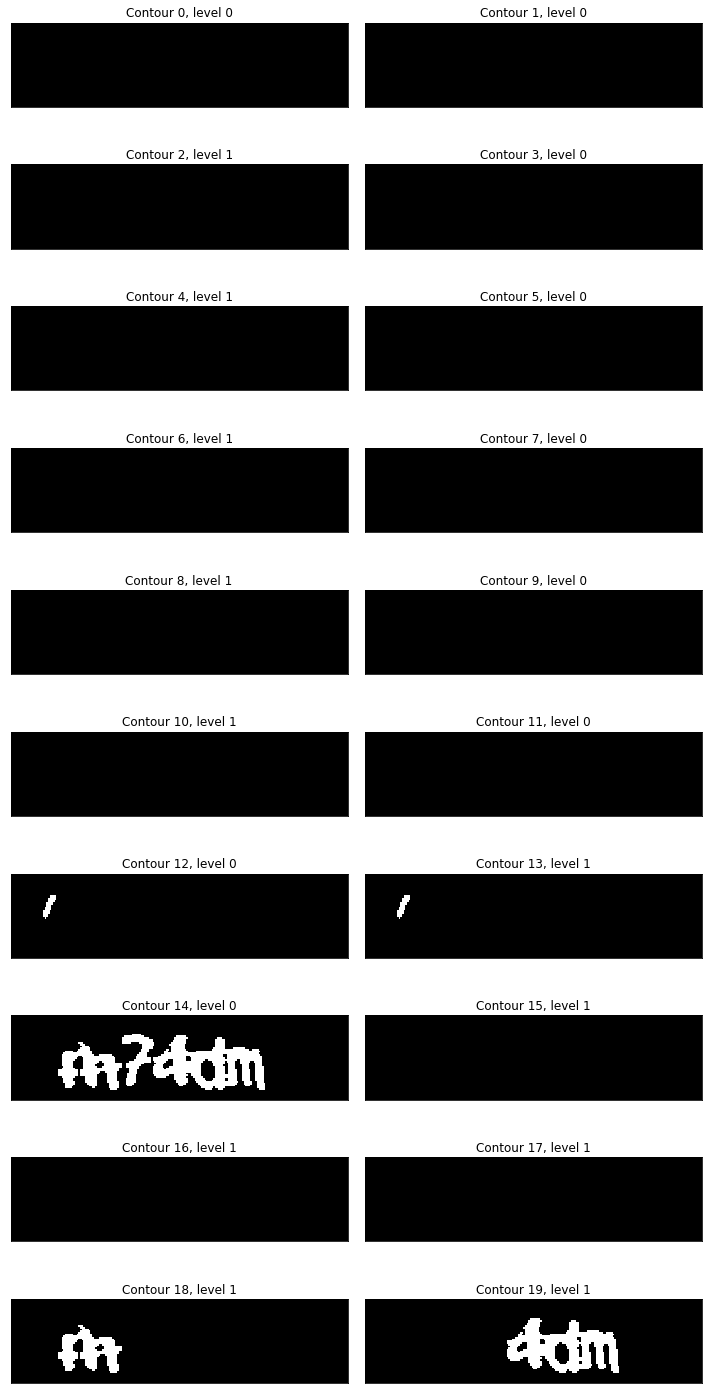

In [21]:
cols = 2
rows = len(contours) // 2
if cols % 2 > 0:
    rows += 1
    
fig, ax = plt.subplots(rows, cols, figsize=(10, rows*2))
for i in range(0, rows):
    for j in range(0, cols):
        index = i * cols + j
        if index >= len(contours):
            ax[i, j].set_visible(False)
        else:
            plt.sca(ax[i, j])
            
            mask = cv.fillPoly(np.zeros(processed.shape).astype(np.uint8), [contours[index]], (255, 255, 255))
            img = cv.bitwise_and(processed, mask)
            
            show_image(img)
            plt.title('Contour {}, level {}'.format(index, contour_levels[index]))

plt.tight_layout()